In [1]:
import time
import json
import random
import numpy as np
from qiskit import *
from qiskit import Aer
import tensorflow as tf
from qiskit import IBMQ
import matplotlib.pyplot as plt
from qiskit.circuit import Reset
from IPython.display import display
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.random import random_circuit
from qiskit.circuit.exceptions import CircuitError
from sympy.utilities.iterables import multiset_permutations
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit

from qiskit.circuit.library.standard_gates import (
    IGate,
    U1Gate,
    U2Gate,
    U3Gate,
    XGate,
    YGate,
    ZGate,
    HGate,
    SGate,
    SdgGate,
    TGate,
    TdgGate,
    RXGate,
    RYGate,
    RZGate,
    CXGate,
    CYGate,
    CZGate,
    CHGate,
    CRZGate,
    CU1Gate,
    CU3Gate,
    SwapGate,
    RZZGate,
    CCXGate,
    CSwapGate,
)

In [2]:
IBMQ.save_account('de404b7eba21afacf3e900bcd1cc1244967cecad8f7051683e08ff88d444aee2e6cb029f51036d2eb8efd6f18bd04acf5d9bc0891891ebe4c1bb1ab062f7741b', overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def random_circuit(num_qubits, depth, max_operands=3, measure=False, conditional=False, reset=False, seed=None):
    """Generate random circuit of arbitrary size and form.

    This function will generate a random circuit by randomly selecting gates
    from the set of standard gates in :mod:`qiskit.extensions`. For example:

    .. jupyter-execute::

        from qiskit.circuit.random import random_circuit

        circ = random_circuit(2, 2, measure=True)
        circ.draw(output='mpl')

    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        max_operands (int): maximum operands of each gate (between 1 and 3)
        measure (bool): if True, measure all qubits at the end
        conditional (bool): if True, insert middle measurements and conditionals
        reset (bool): if True, insert middle resets
        seed (int): sets random seed (optional)

    Returns:
        QuantumCircuit: constructed circuit

    Raises:
        CircuitError: when invalid options given
    """
    if max_operands < 1 or max_operands > 3:
        raise CircuitError("max_operands must be between 1 and 3")

    one_q_ops = [
        IGate,
        U1Gate,
        U2Gate,
        U3Gate,
        XGate,
        YGate,
        ZGate,
        HGate,
        SGate,
        SdgGate,
        TGate,
        TdgGate,
        RXGate,
        RYGate,
        RZGate,
    ]
    one_param = [U1Gate, RXGate, RYGate, RZGate, RZZGate, CU1Gate, CRZGate]
    two_param = [U2Gate]
    three_param = [U3Gate, CU3Gate]
    two_q_ops = [CXGate]
    three_q_ops = [CCXGate, CSwapGate]

    qr = QuantumRegister(num_qubits, "q")
    qc = QuantumCircuit(num_qubits)

    if measure or conditional:
        cr = ClassicalRegister(num_qubits, "c")
        qc.add_register(cr)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(num_qubits))
        rng.shuffle(remaining_qubits)
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = 2
            operands = [remaining_qubits.pop() for _ in range(num_operands)]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            elif num_operands == 3:
                operation = rng.choice(three_q_ops)
            if operation in one_param:
                num_angles = 1
            elif operation in two_param:
                num_angles = 2
            elif operation in three_param:
                num_angles = 3
            else:
                num_angles = 0
            angles = [rng.uniform(0, 2 * np.pi) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            # with some low probability, condition on classical bit values
            if conditional and rng.choice(range(10)) == 0:
                value = rng.integers(0, np.power(2, num_qubits))
                op.condition = (cr, value)

            qc.append(op, register_operands)

    if measure:
        qc.measure(qr, cr)

    return qc

In [4]:
def gatecount(qc, transpiled_circuit):
    count = transpiled_circuit.count_ops()
    items = list(count.items())
    pieces = len(items)
    new_arrays = np.array_split(items, pieces)
    new_arrays
    for i in range(pieces):
        if(new_arrays[i][0][0] == 'cx'):
            cnotcount = int(new_arrays[i][0][1])
            
    #print('Gate Counts -')
    #print(json.dumps(count,indent=4))
    return cnotcount
    
def plothistogram(qc, job):
    fig = plot_histogram(job.result().get_counts())
    display(fig)

def run(qc, layout, computer, plot=0):
    if (computer == 0):
        backend = Aer.get_backend('qasm_simulator')
        
    else:
        provider = IBMQ.get_provider(hub='ibm-q', group='open')
        small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
        backend = least_busy(small_devices)
        
    transpiled_circuit = transpile(qc, backend, initial_layout=layout)
    #job = execute(qc, backend, shots = 1024)
    print("Quantum Computer in Use:", str(backend))
    #job_monitor(job)
    #device_result = job.result()
    
    if(plot==1):
        plothistogram(qc, job)
    
    cx = gatecount(qc, transpiled_circuit)
    
    return cx

def getfeatures(qc):
    gatedata = []
    for gate in qc.data:
        if (gate[0].name == 'cx'):
            gatedata.append(gate[1])
    gatedata = np.array(gatedata)
    l = np.shape(gatedata)[0]

    cnotarray = np.zeros([l,2], dtype=int)
    for i in range(l):
        cnotarray[i][0] = gatedata[i][0].index
        cnotarray[i][1] = gatedata[i][1].index
    return cnotarray.flatten()

def getqiskitlayout(qc, backend, plot = 0):
    transpiled_circuit = transpile(qc, backend, optimization_level=3) 
    bits = transpiled_circuit._layout.get_physical_bits()
    
    if(plot==1):
        fig = plot_circuit_layout(transpiled_circuit, backend)
        display(fig)    
        #for i in range(5):
            #print(transpiled_circuit._layout.get_physical_bits()[i])

    qiskitlayout = []
    for i in range(len(bits)):
        regtype = transpiled_circuit._layout.get_physical_bits()[i].register.qasm()
        if(regtype.find('ancilla')==-1):
            qiskitlayout.append(transpiled_circuit._layout.get_physical_bits()[i].index)
        else :   
            qiskitlayout.append(-1)
            
    return np.array(qiskitlayout)

def elementgen(qubitno, depth, backend, plot=0):
    qc = random_circuit(qubitno, depth, measure=True)
    if(plot == 1):
        fig = qc.draw(output='mpl')
        display(fig)
        
    x = getfeatures(qc)
    y = getqiskitlayout(qc, backend, plot)
    
    return x, y

def datagen(size, qubitno, backend):
    train = []
    target = []
    for i in range(size):
        x, y = elementgen(qubitno=qubitno, depth=random.randint(1,40), backend=backend, plot=0)
        train.append(x)
        target.append(y)
        if(i%1000 == 0):
            print("Iteration", i)

    return train, target

def get_key(val, dictionary):
    for key, value in dictionary.items():
        if (np.array_equal(val, value)):
            return key
    return "Key doesn't exist"

def targetdatagen(targetraw, layoutdict):
    y = []
    for i in range(datasetsize):
        index = get_key(targetraw[i], layoutdict)
        output = onehotdict[index]
        y.append(output)
    
    return y

In [5]:
#for gate in qc.data:
#    print('\ngate name:', gate[0].name)
#    print('qubit(s) acted on:', gate[1])

In [6]:
provider = IBMQ.get_provider(hub='ibm-q', group='open')
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
#backend = least_busy(small_devices)
    
my_provider = IBMQ.get_provider()
backend  = my_provider.get_backend('ibmq_lima')

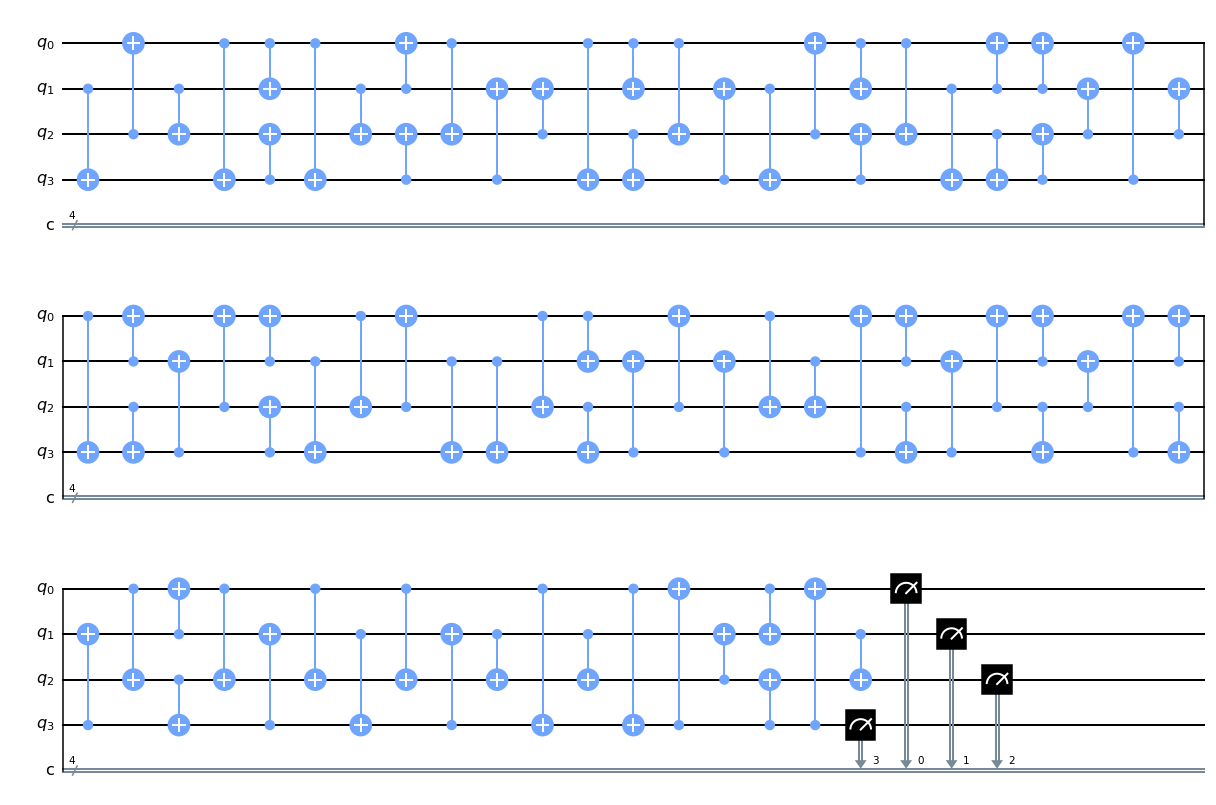

C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:51: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][0] = gatedata[i][0].index
C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:52: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][1] = gatedata[i][1].index


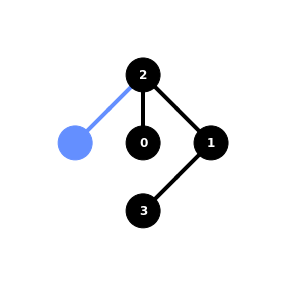

(164,)
[-1  2  0  1  3]


C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:67: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  regtype = transpiled_circuit._layout.get_physical_bits()[i].register.qasm()
C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:69: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qiskitlayout.append(transpiled_circuit._layout.get_physical_bits()[i].index)


In [7]:
p, q = elementgen(qubitno=4, depth=random.randint(1,50), plot=1, backend=backend)
print(np.shape(p))
print(q)

In [8]:
qubitno = 4
datasetsize = 75000
trainraw, targetraw = datagen(size=datasetsize, qubitno=qubitno, backend=backend)

C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:51: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][0] = gatedata[i][0].index
C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:52: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][1] = gatedata[i][1].index
C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:67: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  regtype = transpiled_circuit._layout.get_physical_bits()[i].register.qasm()
C:\Users\aniru\AppData\Local\Temp/ipykernel_24704/3536243312.py:69: DeprecationWarning: Back-references to from Bit instances to their 

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000
Iteration 30000
Iteration 31000
Iteration 32000
Iteration 33000
Iteration 34000
Iteration 35000
Iteration 36000
Iteration 37000
Iteration 38000
Iteration 39000
Iteration 40000
Iteration 41000
Iteration 42000
Iteration 43000
Iteration 44000
Iteration 45000
Iteration 46000
Iteration 47000
Iteration 48000
Iteration 49000
Iteration 50000
Iteration 51000
Iteration 52000
Iteration 53000
Iteration 54000
Iteration 55000
Iteration 56000
Iteration 57000
Iteration 58000
Iteration 59000
Iteration 60000
Iteration 61000
Iteration 62000
Itera

In [9]:
layouts = np.array([-1, 0, 1, 2, 3])
arr = []
for p in multiset_permutations(layouts):
    arr.append(p)
layoutdict = dict(enumerate(arr, 0))

encoded = np.zeros([120,120], dtype = int)
for i in range(120):
    for j in range(120):
        if(i==j):
            encoded[i][j] = 1
onehotdict = dict(enumerate(encoded, 0))

x_data = trainraw
y_data = targetdatagen(targetraw, layoutdict)

In [10]:
#index = get_key([3, 2, 0, 1, -1], layoutdict)
#print(index)
#print(onehotdict[index])

In [11]:
max_length = max(len(row) for row in x_data)
x_data = np.array([np.pad(row, (0, max_length-len(row))) for row in x_data])

In [12]:
np.savetxt('x_data.txt', x_data, fmt='%d')
np.savetxt('y_data.txt', y_data, fmt='%d')